# Generalized Additive Models (GAM)

While linear models are valuable, sometimes we need a bit more flexibility. We have a few options to overcome linearity constraints in our statistical models:

1. Adding higher order parameters to our linear model
2. Strictly non-parametric modeling
3. Semi-parametric models

## Higher Orders in OLS

When estimating the effect of age (or experience) on earnings for workers, we frequently discuss a pattern that is called the "earnings-experience profile". This pattern looks like the following chart: 

![](https://taxfoundation.org/wp-content/uploads/2019/03/PaF-Chart-121.png)

It is clear that this graph does not demonstrate a linear relationship between age (a proxy for experience) and earnings. It looks much more like a quadratic equation to me. How can we incorporate that functional form into a linear model?

It turns out that OLS's assumptions state that the relationship between a paramter and the dependent variabe be linear, but not necessarily that the parameter itself be linear. What we can do to sidestep this problem is to simply **include non-linear terms in our regression model**. Let's look at a simple regression equation:

$$ y_i = \alpha + \beta \cdot x_i + \epsilon_i $$

The REQUIRED linearity stipulates that $\beta \cdot x_i$ be a linear relationship, or in other words that $\beta$ be a number (not some other type of functional form). If we want to consider a non-linear relationship between $y$ and $x$, then we can adjust our regression model like this:

$$ y_i = \alpha + \beta_1 \cdot x_{i} + \beta_2 \cdot x^2_{i} + \epsilon_i $$

Now, we still have a linear relationshipe between each parameter and our dependent variable ($y$), but we have created a second parameter based on our original $x$ variable: $x^2$. Thus, we can estimate the quadratic relationship between $x$ and $y$ using linear regression. The marginal effect of increasing $x$ by one unit in this model is no longer $\beta(x_{old}-x_{new})$. Now, it is $\beta_1(x_{old}-x_{new}) + \beta_2(x_{old}^2-x_{new}^2)$, and depends on the **current $x$ values**!


## Non-parametric Modeling

Another alternative is to simply abandon the parametric nature of OLS, and allow our model to assume **any** functional form. Thus, the relationship between $y$ and $x$ could be represented as

$$ y_i = f(x_i) + \epsilon_i $$

where $f()$ can be any functional form. We can then have ANY relationship between $x$ and $y$, and are not hindered by any restrictions or assumptions in our model.

Why don't we do this? I'll give you two reasons. First, it quickly becomes computationally intensive. The most common method for estimation of non-parametric models is through **kernel regression** (you can also use **regression trees** and several other tools, though). These models require large amounts of data in order to estimate, because each portion of the resulting model is in effect calculated based on the nearest observations. This also means that each individual point in the model needs to be separately estimated. While this is reasonable for simple regressions, it becomes complex and slow as the number of variables in a model increase.

Second, when we estimate an entirely non-parametric model, we are likely to generate interaction terms between variables. This means that the effects of one variable cannot be easily separated from the effects of other variables included in our model. If we have two $x$ parameters ($x_1, x_2$), our model can be written

$$ y_i = f(x_1, x_2) + \epsilon_i $$

and the marginal effects of these parameters given the model specified will be

$$ ME_1 = \frac{\partial f}{\partial x_1} $$
and

$$ ME_2 = \frac{\partial f}{\partial x_2} .$$

At this point, we have lost the ability to quickly interpret our marginal effects, and must generate estimates **at any specific observation** of the marginal effect of changes to inputs. In order to have a more flexible model, we have sacrificed both ease of calculation as well as ease of interpretability.

What we really need is some sort of middle ground, and this can be achieved through **Generalized Additive Models**.

## Generalized Additive Models (GAMs)

Generalized Additive Models, or GAMs, provide a nice middle ground between linear models and non-parametric modeling by opening a subclass of non-parametric models to analyze data, while also attempting to preserve interpretability. The restricted flexibility of GAMs is rooted in the restriction to **additively separable** functional forms.

What does that mean? Each explanatory variable must have an **additively separable** form in the regression model. To simplify even further, each variable can have ANY functional form so long as that form **does not interact with the functional forms of other variables**. In math speak, it's like this:

$$ y_i = \sum_{j=1}^K f_j(x_{j,i}) + \epsilon_i $$

If we had two variables again ($x_1, x_2$), then our model would be

$$ y_i = f_1(x_{1,i}) + f_2(x_{2,i}) + \epsilon_i. $$

Our functional form for each variable can take any shape, but must be totally separate for each $x$! This is what we call additively separable, because each function can be added together to become the overall estimate of $y$. Additionally, this makes for some really nice properties when interpreting the model.

- Each functional form can be separately visualized!
- Each functional form relates to only one variable, and so the slope estimates are much easier to calculate when estimating marginal effects.

Let's dive into creating GAMs in Python, and use that experience to learn a bit more about how they work.

## Using GAMs



### Facebook's `Prophet`

There are two libraries that we will cover as we explore the use of GAMs for forecasting. The first is the [`Prophet`](https://facebook.github.io/prophet/) library from Facebook. Using this library, we can create time series-focused GAMs.

`Prophet` expects our data to be structured in very specific ways. Let's import some data and take a look:

In [2]:
# !pip install prophet # Only use this line if prophet is not already installed

import pandas as pd
from prophet import Prophet

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/chicagoBusRiders.csv")

In [3]:
data.head()

,route,date,daytype,rides
0,3,01/01/2001,U,7354
1,4,01/01/2001,U,9288
2,6,01/01/2001,U,6048
3,8,01/01/2001,U,6309
4,9,01/01/2001,U,11207


Now, looking at our `data.head()` values, we can see that there are several columns. `Prophet` wants data to be provided in two columns, named `ds` and `y`, respectively. `ds` should contain the timestamp, and `y` should contain the time series that we want to use.

To fit our data to this structure, let's pick a single bus route, and then reshape our data:

In [4]:
data_p = data.loc[data['route']=='3', ['date', 'rides']]
data_p.columns = ['ds', 'y']

data_p.head()

,ds,y
0,01/01/2001,7354
87,01/02/2001,16697
216,01/03/2001,18195
344,01/04/2001,19424
472,01/05/2001,21221


At this point our data is ready to be used in a `Prophet` model.

In [5]:
m = Prophet()
m.fit(data_p)

14:34:17 - cmdstanpy - INFO - Chain [1] start processing
14:34:19 - cmdstanpy - INFO - Chain [1] done processing


First, we created a `Prophet` model object, and then we used its `fit` method to fit our model to the data for route 3. This fitted model can then be used to create forecasts through which we explore the various seasonal patterns that we might expect to observe on route 3 over time.

In [6]:
# Create an empty dataframe with dates for future periods
future = m.make_future_dataframe(periods=365)
# Fill in dataframe wtih forecasts of `y` for the future periods
forecast = m.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,19217.447760,13074.658575,19022.944522,19217.447760,19217.447760,-3035.340182,-3035.340182,-3035.340182,1451.917361,1451.917361,1451.917361,-4487.257543,-4487.257543,-4487.257543,0.0,0.0,0.0,16182.107578
1,2001-01-02,19218.016024,14860.260189,20527.374688,19218.016024,19218.016024,-1567.573651,-1567.573651,-1567.573651,2832.429275,2832.429275,2832.429275,-4400.002925,-4400.002925,-4400.002925,0.0,0.0,0.0,17650.442374
2,2001-01-03,19218.584289,14510.848919,20529.686300,19218.584289,19218.584289,-1550.462701,-1550.462701,-1550.462701,2729.382262,2729.382262,2729.382262,-4279.844963,-4279.844963,-4279.844963,0.0,0.0,0.0,17668.121588
3,2001-01-04,19219.152553,14515.999784,20688.163330,19219.152553,19219.152553,-1758.234482,-1758.234482,-1758.234482,2371.290928,2371.290928,2371.290928,-4129.525410,-4129.525410,-4129.525410,0.0,0.0,0.0,17460.918071
4,2001-01-05,19219.720818,14842.911804,20938.960302,19219.720818,19219.720818,-1183.814677,-1183.814677,-1183.814677,2768.477918,2768.477918,2768.477918,-3952.292595,-3952.292595,-3952.292595,0.0,0.0,0.0,18035.906141


C:\Users\prabh\AppData\Local\Temp\ipykernel_2992\279601209.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


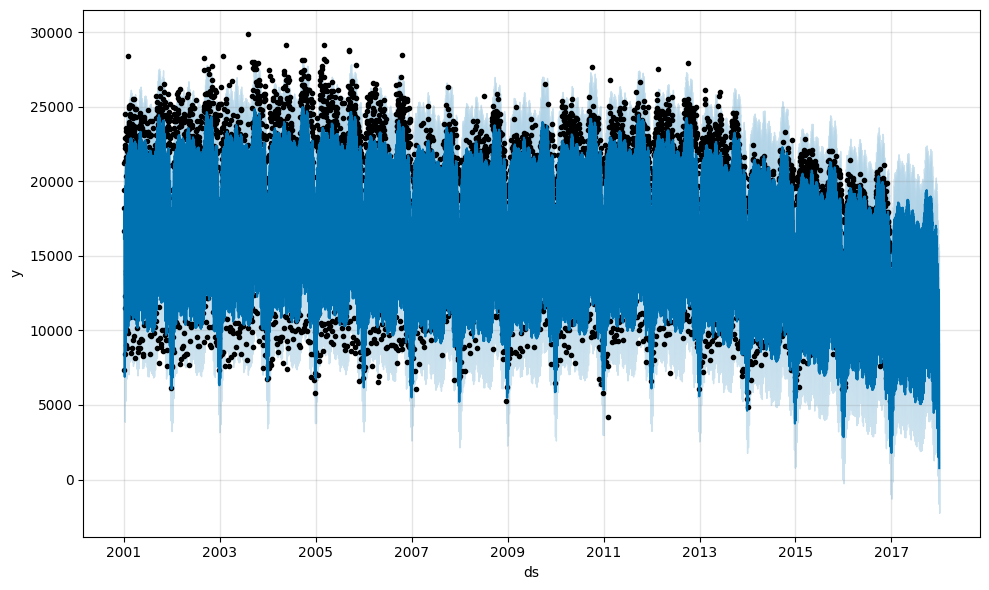

In [7]:
# Plot our model together with the forecast
fig = m.plot(forecast)
fig.show()

C:\Users\prabh\AppData\Local\Temp\ipykernel_2992\38927073.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


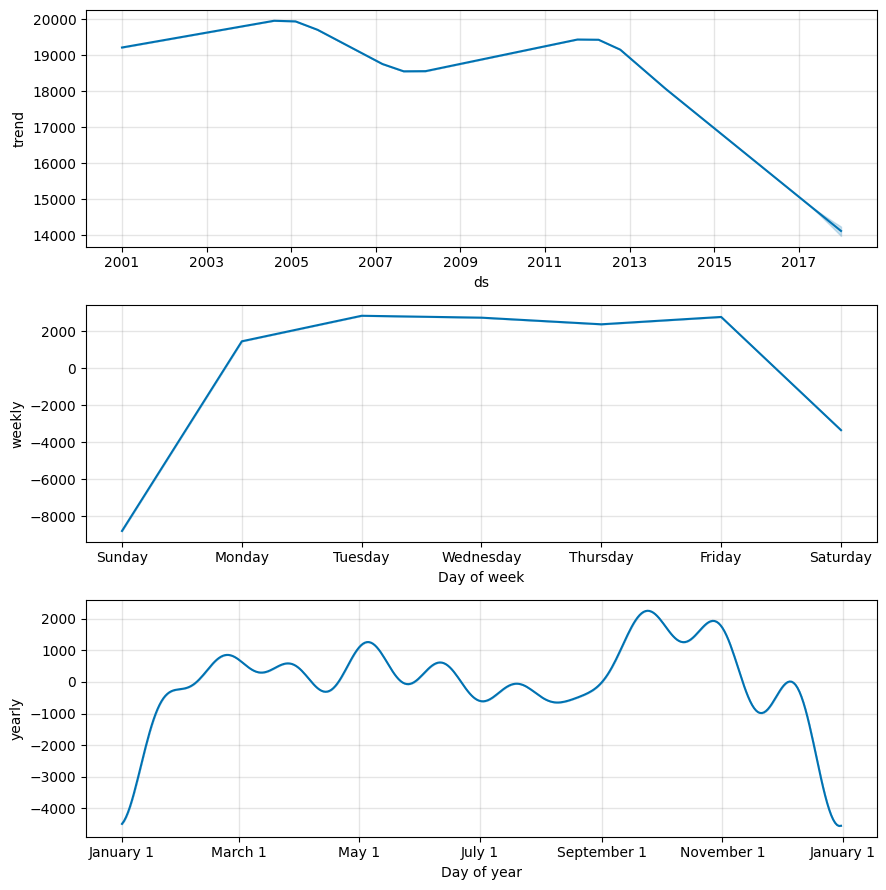

In [8]:
# Plot the components of the forecast
fig = m.plot_components(forecast)
fig.show()

Using these figures, we can explore how our model performs in-sample, what projections look like for future periods, and how different types of cyclicality or seasonality apply to our current model. If we want to explore the raw forecast numbers for our model, we can just use our `forecast` DataFrame to extract that information:

In [9]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2001-01-01,16182.107578
1,2001-01-02,17650.442374
2,2001-01-03,17668.121588
3,2001-01-04,17460.918071
4,2001-01-05,18035.906141


While useful for time series data, `Prophet` lacks the kind of flexibility that would allow us to easily incorporate both time series and exogenous factors into our model. Let's look at a more flexible implementation of the GAM model.

## `pyGAM`'s alternative implementation

My preferred GAM library is the `pyGAM` library. It allows for really neat and flexible solutions, using GAMs not only for time series analysis, but also for more general data analysis. Let's get an example going and take a look at why.

In [17]:
# Import libraries/functions
from pygam import LinearGAM, s, f, l
import pandas as pd

# Read in data, select route 3
data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/chicagoBusRiders.csv")
data_p = data.loc[data['route']=='3']
data_p['date'] = pd.to_datetime(data_p['date'])
data_p['year'] = data_p['date'].dt.year
data_p['month'] = data_p['date'].dt.month
data_p['day'] = data_p['date'].dt.weekday

ImportError: cannot import name '_center' from 'numpy._core.umath' (c:\Users\prabh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\umath.py)

In [ ]:
data_p.head()

In [ ]:
x = data_p[['year', 'month', 'day']]
y = data_p['rides']

With `pyGAM`, we do need to do all of the data processing manually, so we are creating the parsed time data using `pandas`' built-in functions to create columns for year, month, and day of the week. Once we have our data processed, we can fit our model.

In [ ]:
gam = LinearGAM(s(0) + s(1) + f(2))
gam = gam.gridsearch(x.values, y)

There are a few things going on here. First, we need to create our actual GAM model. This is done by creating an instance of the `LinearGAM` class. The argument that we provide to this class is similar to a regression equation. What we need to provide are the **functional forms** of the parameters to be included in our model.

When we imported `pyGAM`, we also imported `s`, `f`, and `l`. `s` stands for **spline**, and represents our most general functional form. Splines can be used to estimate functions of any shape, and so they are the key component of a GAM as enablers of highly flexible functional form.

`f` creates a factor-based functional form, and is useful where data is encoded as numbers which are categorial (rather than ordinal) in nature. This allows us to see the different level effects of each encoded factor in the column.

`l` creates a linear functional form. This can be useful where we expect the relationship between $x$ and $y$ by constraining the relationship to be linear rather than smooth. Remember that linear functional forms are by far the easiest to interpret, so we want to use them wherever they are representative of truth!

In our case, we want to see the spline-based relationship between year and rides and month and rides, but days are better treated as factors. This means that the most effective "regression equation" is `s(0) + f(1) + f(2)`, with 0, 1, and 2 denoting the respective columns in our `x` data array.

Now, let's make ourselves a nice plot of the results:

This looks a lot more complicated than `Prophet`, and it is! The added complexity is due to increased flexibility. That flexibility becomes apparent when we want to add more than the same factors that we could use in Prophet. Let's try to model something different and see what happens.

In [ ]:
data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/auto-mpg.csv")

In [ ]:
data.head()

In this case, our model has nothing to do with time-series analysis, but we will still be able to create a nice GAM. We can also create GAMs that combine time series patterns as well as other types of factors using `pyGAM`, and can use more varied data types as we do so.

In [ ]:
titles = ['modelYear', 'acceleration', 'weight', 'horsepower', 'displacement','cylinders']

x = data[titles]
y = data['mpg']

# Creating a factor for cylinders since it is not continuous like the other information
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam = gam.gridsearch(x.values, y)

# Create the subplots in a single-row grid
fig = tools.make_subplots(rows=2, cols=3, subplot_titles=titles)
# Dictate the size of the figure, title, etc.
fig['layout'].update(height=500, width=1000, title='pyGAM', showlegend=False)

# Loop over the titles, and create the corresponding figures
for i, title in enumerate(titles):
    # Create the grid over which to estimate the effect of parameters
    XX = gam.generate_X_grid(term=i)
    # Calculate the value and 95% confidence intervals for each parameter
    # This will become the expected effect on the dependent variable for a given value of x
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    
    # Create the effect and confidence interval traces (there are 3 total)
    trace = go.Scatter(x=XX[:,i], y=pdep, mode='lines', name='Effect')
    ci1 = go.Scatter(x = XX[:,i], y=confi[:,0], line=dict(dash='dash', color='grey'), name='95% CI')
    ci2 = go.Scatter(x = XX[:,i], y=confi[:,1], line=dict(dash='dash', color='grey'), name='95% CI')

    if i<3:
        fig.append_trace(trace, 1, i+1)
        fig.append_trace(ci1, 1, i+1)
        fig.append_trace(ci2, 1, i+1)
    else:
        fig.append_trace(trace, 2, i-2)
        fig.append_trace(ci1, 2, i-2)
        fig.append_trace(ci2, 2, i-2)

#Plot the figure
py.iplot(fig)

Even though it took some effort to set up the original model, now that we have template code, we can quickly adapt it to pretty much any data, and get some really interesting figures back. These figures are the basis for our ability to interpret GAMs. The biggest reason for visualization is the power it has to translate our data to intuitive results for non-experts.

We can, of course, also create forecasts using our `pyGAM` models:

In [ ]:
pred = gam.predict(data.loc[3, titles].values.reshape(1,6))

print("Truth was {0:.2f}, prediction was {1:.2f}, the model was off by {2:.2f}.".format(data.loc[3,'mpg'], float(pred), data.loc[3,'mpg']-float(pred)))`

**Reading Reflection**

Which of the two GAM libraries do you think will be more useful to you? Describe a situation in which you could use GAM, and why the library you picked would be preferable in that context. Submit on Canvas.

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pygam import LinearGAM, s

# Load dataset
url = "https://github.com/dustywhite7/Econ8310/raw/master/DataSets/auto-mpg.csv"
data = pd.read_csv(url)

# Drop missing values
data = data.dropna()

# Convert 'horsepower' column to numeric
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
data = data.dropna()

# Define features and target
X = data[['horsepower']].values
y = data['mpg'].values

# Fit a GAM model with a smoothing spline
gam = LinearGAM(s(0)).fit(X, y)

# Generate predictions
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = gam.predict(X_pred)
confidence_intervals = gam.confidence_intervals(X_pred)

# Plot results using Plotly
fig = go.Figure()

# Scatter plot for actual data
fig.add_trace(go.Scatter(
    x=X.flatten(), y=y, mode='markers',
    name='Data', marker=dict(color='blue')
))

# Line plot for GAM fit
fig.add_trace(go.Scatter(
    x=X_pred.flatten(), y=y_pred, mode='lines',
    name='GAM Fit', line=dict(color='red')
))

# Confidence interval (lower bound)
fig.add_trace(go.Scatter(
    x=X_pred.flatten(), y=confidence_intervals[:, 0], mode='lines',
    name='Lower CI', line=dict(dash='dot', color='gray')
))

# Confidence interval (upper bound)
fig.add_trace(go.Scatter(
    x=X_pred.flatten(), y=confidence_intervals[:, 1], mode='lines',
    name='Upper CI', line=dict(dash='dot', color='gray')
))

# Update layout
fig.update_layout(
    title="GAM Fit using pyGAM",
    xaxis_title="Horsepower",
    yaxis_title="MPG",
    template="plotly_white"
)

# Show plot
fig.show()